In [27]:
import gym
import numpy as np
import random
import tensorflow as tf
from collections import deque
from IPython import display
from matplotlib import pyplot as plt
import time

In [28]:
class DuelingDQN:

    def __init__(self, input_shape, output_shape):

        self.feature_layers = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(16, activation='relu', input_shape=input_shape),
                                    tf.keras.layers.Dense(32, activation='relu')])

        self.value_layers = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(1, activation='linear', 
                                    input_shape=self.feature_layers.output_shape)])
        
        self.advantage_layers = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(output_shape, activation='linear', 
                                    input_shape=self.feature_layers.output_shape)])

        self.optimizer = tf.keras.optimizers.Adam()
    
    def forward(self, input_data):

        features = self.feature_layers(input_data)
        values = self.value_layers(features)
        advantages = self.advantage_layers(features)

        q_values =  values + (advantages - np.mean(advantages))

        return q_values

    def predict(self, input_data):

        features = self.feature_layers(input_data)
        values = self.value_layers(features)
        advantages = self.advantage_layers(features)

        q_values =  values + (advantages - np.mean(advantages))

        return q_values.numpy()

    def set_weights(self, another_model):

        self.feature_layers.set_weights(
            another_model.feature_layers.get_weights())

        self.value_layers.set_weights(
            another_model.value_layers.get_weights())

        self.advantage_layers.set_weights(
            another_model.advantage_layers.get_weights())

    def fit(self, X, Y):

        with tf.GradientTape(persistent=True) as tape:

            predictions = self.forward(X)
            loss = tf.keras.losses.MSE(Y, predictions)

        feat_grads = tape.gradient(loss, self.feature_layers.trainable_variables)
        self.optimizer.apply_gradients(zip(feat_grads, self.feature_layers.trainable_variables))

        val_grads = tape.gradient(loss, self.value_layers.trainable_variables)
        self.optimizer.apply_gradients(zip(val_grads, self.value_layers.trainable_variables))

        adv_grads = tape.gradient(loss, self.advantage_layers.trainable_variables)
        self.optimizer.apply_gradients(zip(adv_grads, self.advantage_layers.trainable_variables))


class DQNAgent:

    def __init__(self, env, episodes=5_000, discount=0.99, epsilon_decay=0.9955, 
        min_epsilon=0.001, replay_memory_size=50_000, min_replay_memory_size=5_000, 
                 update_target_model_frequency=5, mini_batch_size=128):
        
        self.env = env
        self.model = self.create_model()
        self.target_model = self.create_target_model()
        self.target_update_counter = 0
        self.episodes = episodes
        self.discount = discount
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.replay_memory_size = replay_memory_size
        self.replay_memory = deque(maxlen=self.replay_memory_size)
        self.min_replay_memory_size = min_replay_memory_size
        self.update_target_model_frequency = update_target_model_frequency
        self.mini_batch_size = mini_batch_size
        self.env.reset()

    def create_model(self):
        
        return DuelingDQN(self.env.observation_space.shape, self.env.action_space.n)

    def create_target_model(self):

        target_model = self.create_model()
        target_model.set_weights(self.model)

        return target_model

    def update_replay_memory(self, transition):
        # transition is tuple of (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def get_qs(self, state):

        return self.model.forward(np.array(state).reshape(-1, *state.shape))

    def train(self, terminal_state):

        if len(self.replay_memory) < self.min_replay_memory_size:
            print("NOT YET")
            return False

        minibatch = random.sample(self.replay_memory, self.mini_batch_size)

        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)

        future_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(future_states)

        X = []
        Y = []
        
        for index, (current_state, action, reward, future_state, done) in enumerate(minibatch):

            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + self.discount * max_future_q

            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            X.append(current_state)
            Y.append(current_qs)

        self.model.fit(np.array(X), np.array(Y))

        if terminal_state:
            self.target_update_counter += 1
        
        if self.target_update_counter > self.update_target_model_frequency:
            self.target_model.set_weights(self.model)
            self.target_update_counter = 0

        return True

In [29]:
episode_rewards = []
epsilon = 1

env = gym.make('Acrobot-v1')
env.reset()

agent = DQNAgent(env, episodes=1500)


for episode in range(agent.episodes):
    try:
        episode_reward = 0
        step = 0
        current_state = agent.env.reset()

        done = False

        display.clear_output(wait=True)
        print(f"IN EPSIODE {episode}")
        if episode_rewards:
            print(f"Average Rewards : {sum(episode_rewards) / len(episode_rewards)}")

        while not done:

            if np.random.random() > epsilon:
                action = np.argmax(agent.get_qs(current_state))

            else:
                action = agent.env.action_space.sample()

            new_state, reward, done, info = agent.env.step(action)

            episode_reward += reward

            agent.update_replay_memory((current_state, action, reward, new_state, done))
            ret = agent.train(done) 

            current_state = new_state
            step += 1

        if ret:
            episode_rewards.append(episode_reward)

        if epsilon > agent.min_epsilon:
            epsilon *= agent.epsilon_decay
            epsilon = max(epsilon, agent.min_epsilon)
    except KeyboardInterrupt:
        plt.plot(list(range(len(episode_rewards))), episode_rewards)
        plt.show()
        time.sleep(10)

IN EPSIODE 1499
Average Rewards : -130.37753721244925


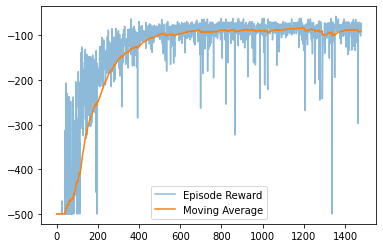

In [34]:
prev = 0
mva = []

k = 2 / (101)

for el in episode_rewards:

    if prev != 0:
        pres = prev * (1 - k) + el * k
    else:
        pres = el
    prev = pres
    mva.append(pres)
plt.plot(list(range(len(episode_rewards))), episode_rewards, alpha=0.5, label="Episode Reward")
plt.plot(list(range(len(mva))), mva, label="Moving Average")
plt.legend()